In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Lecture 22

##  Convolutional Neural Network (CNN)
- Fashion MNIST
- Dataset From CSV File

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

%matplotlib inline

2024-05-27 20:24:58.111260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 20:24:58.111303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 20:24:58.112434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 20:24:58.118362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 20:24:58.867933: W tensorflow/compiler/tf2

In [3]:
###----------------------
### Some basic parameters
###----------------------


inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'fashion_mnist'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 10 # number of cycles to run
PATIENCE = 5

BATCH_SIZE = 32 # inline of Traing Rows being 60000

# Set parameters for decoration of plots
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-05-27 20:24:59.557570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 20:24:59.593764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 20:24:59.594007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
print (physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Helper Function

In [6]:
def fn_plot_label(train_df : pd.DataFrame, test_df : pd.DataFrame):
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)

    ax = train_df['label'].value_counts().plot(kind='bar',
                                               title="Training distribution",
                                               color = 'DarkBlue', alpha = 0.8)


    plt.subplot(1,2,2)
    
    ax = test_df['label'].value_counts().plot(kind='bar',
                                              title="Testing distribution",
                                              color = 'Orange', alpha = 0.8)

## Using MNIST Fashion data

### Labels

Total : 785 columns
First column is label remaining columns are pixel values of the images.

Each training and test example is assigned to one of the following labels:


|Label| Class
|:-|:-|
0 | T-shirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle boot

In [7]:
class_labels ={0 : 'T-shirt/top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'
              }

In [8]:
train_filename = os.path.join(inpDir, subDir, 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, subDir, 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [9]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


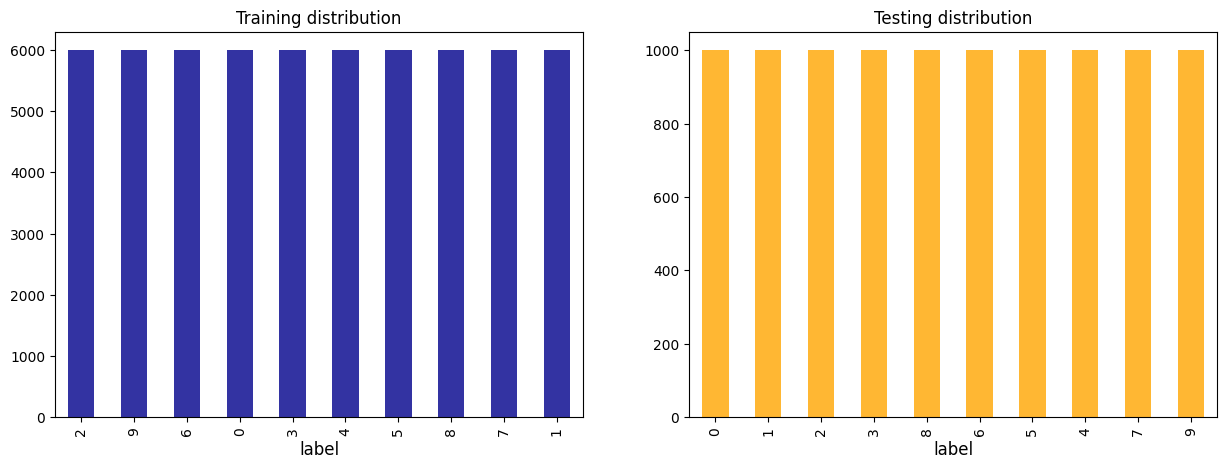

In [11]:
fn_plot_label(train_df, test_df)

## Converting to Datasets

In [12]:
# Each row need to be separated in features and labels
def split_feature_label(row ):
    '''
    Args:
        row: array of 785 values
    returns:
        feature : np.ndarray of shape (28 x 28, 1)
        label: integer
    '''
    
    feature = tf.reshape(row[1:], [28, 28, 1])
    
    label = row[0]
    
    return feature, label

In [13]:
# Create training dataset
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(split_feature_label)

train_ds = train_ds.batch(BATCH_SIZE)

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

2024-05-27 20:25:01.867229: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 20:25:01.867551: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 20:25:01.867767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


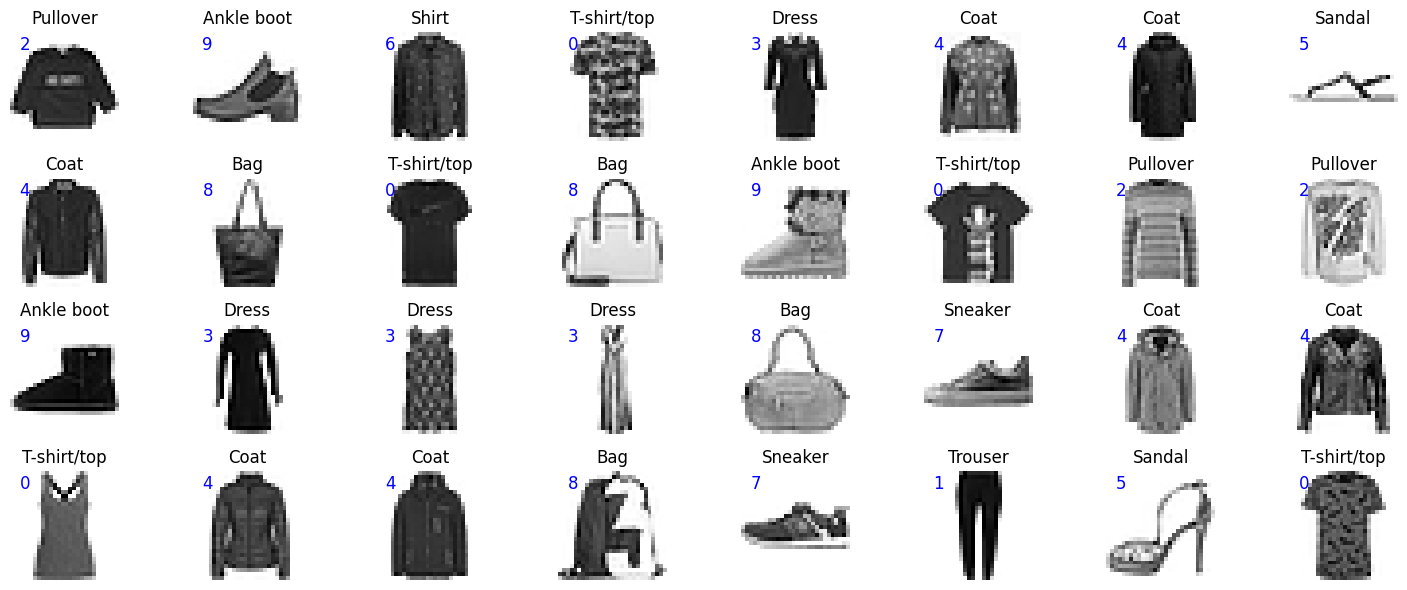

In [14]:
for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

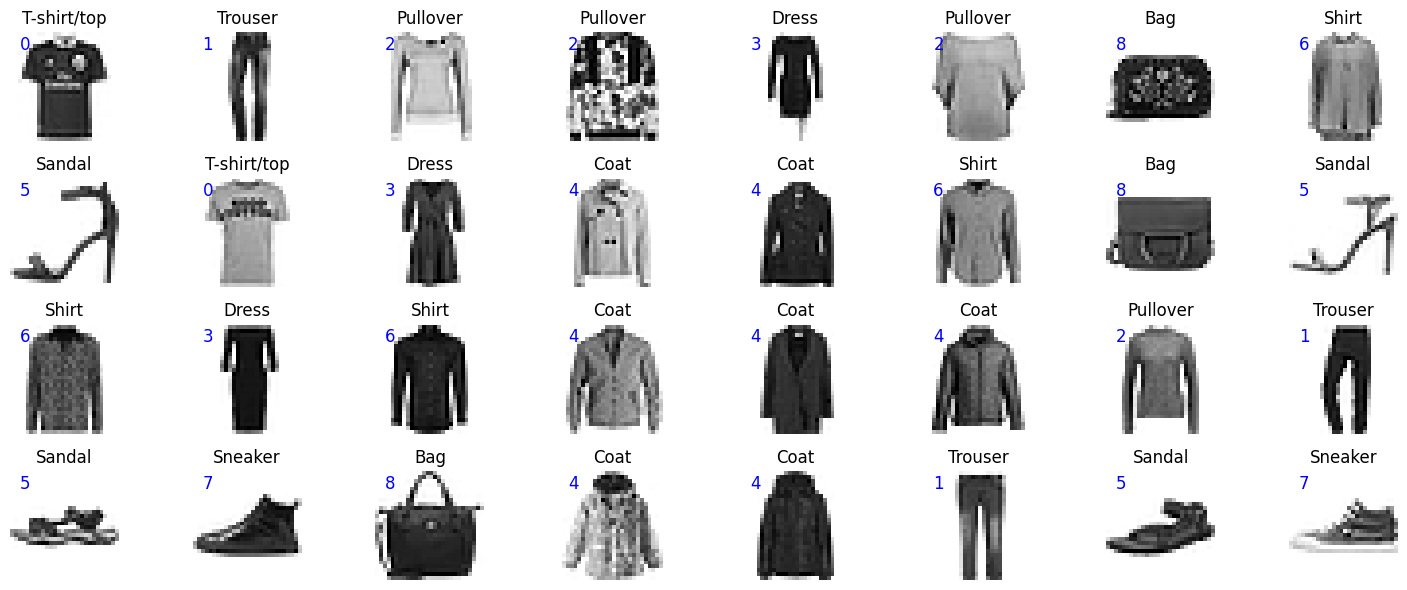

In [15]:
for images, labels in test_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

### Rescaling of images

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

image_batch, labels_batch = next(iter(train_ds))

img = image_batch[0].numpy()

print ('Original Image--- Min pixel:', img.min(), ' | Max pixel:', img.max())

print ('-'*50)


# apply it to the dataset by calling map

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))

img = image_batch[0].numpy()

print ('Normalized Image--- Min pixel:', img.min(), ' | Max pixel:', img.max())

Original Image--- Min pixel: 0  | Max pixel: 255
--------------------------------------------------
Normalized Image--- Min pixel: 0.0  | Max pixel: 1.0


In [17]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Convolution Layer in Action

In [18]:
input_shape = (1, 6, 6, 1)
X = tf.random.normal(input_shape)
#X = tf.fill(input_shape, 1.0)
X.shape

TensorShape([1, 6, 6, 1])

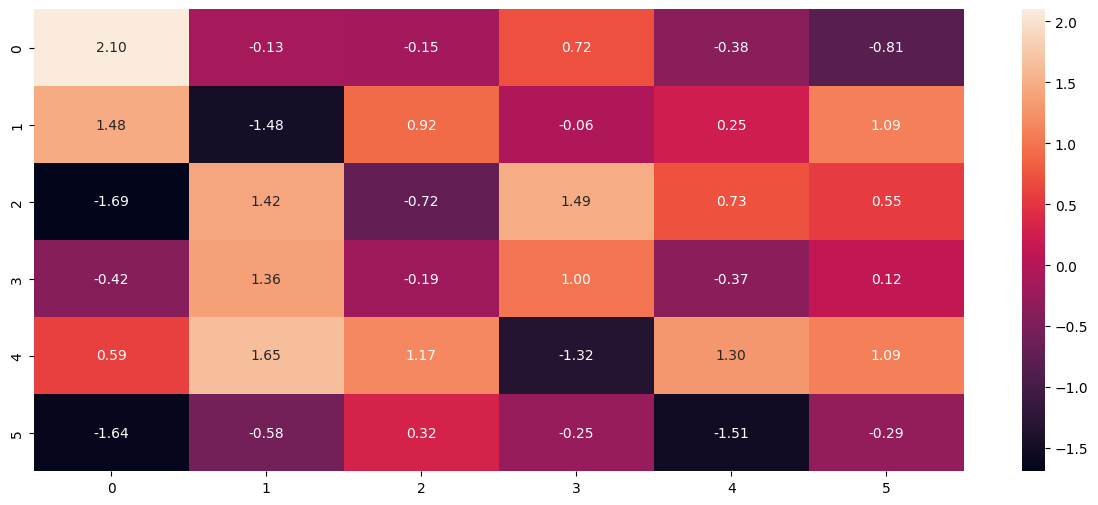

In [19]:
import seaborn as sns

sns.heatmap(X.numpy()[0,:,:,0], annot=True, fmt=".2f");

In [20]:
tf.constant_initializer(1.).value

1.0

In [21]:
y = tf.keras.layers.Conv2D(1, 3,
                           kernel_initializer=tf.constant_initializer(1.),
                           use_bias = False,
                           activation='relu', 
                           input_shape=input_shape[1:])(X)
y.shape

2024-05-27 20:25:05.846871: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


TensorShape([1, 4, 4, 1])

Arguments|Description
:--|:--
filters|Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
kernel_size|An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
strides|An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
padding|one of "valid" or "same" (case-insensitive).
data_format|A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch_size, height, width, channels) while channels_first corresponds to inputs with shape (batch_size, channels,height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be channels_last.
dilation_rate|an integer or tuple/list of 2 integers, specifying the dilation rate to use for dilated convolution. Can be a single integer to specify the same value for all spatial dimensions. Currently, specifying any dilation_rate value != 1 is incompatible with specifying any stride value != 1.
groups|A positive integer specifying the number of groups in which the input is split along the channel axis. Each group is convolved separately with filters / groups filters. The output is the concatenation of all the groups results along the channel axis. Input channels and filters must both be divisible by groups.
activation|Activation function to use. If you don't specify anything, no activation is applied (see keras.activations).
use_bias|Boolean, whether the layer uses a bias vector.
kernel_initializer|Initializer for the kernel weights matrix (see keras.initializers).
bias_initializer|Initializer for the bias vector (see keras.initializers).
kernel_regularizer|Regularizer function applied to the kernel weights matrix (see keras.regularizers).
bias_regularizer|Regularizer function applied to the bias vector (see keras.regularizers).
activity_regularizer|Regularizer function applied to the output of the layer (its "activation") (see keras.regularizers).
kernel_constraint|Constraint function applied to the kernel matrix (see keras.constraints).
bias_constraint|Constraint function applied to the bias vector (see keras.constraints).

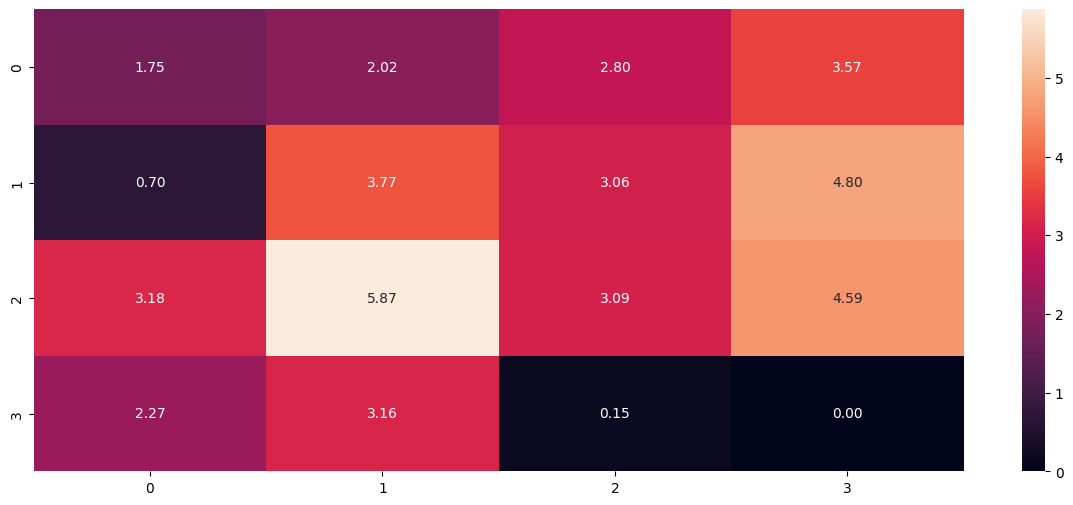

In [22]:
sns.heatmap(y.numpy()[0,:,:,0], annot=True, fmt=".2f");

## MaxPool Layer in Action

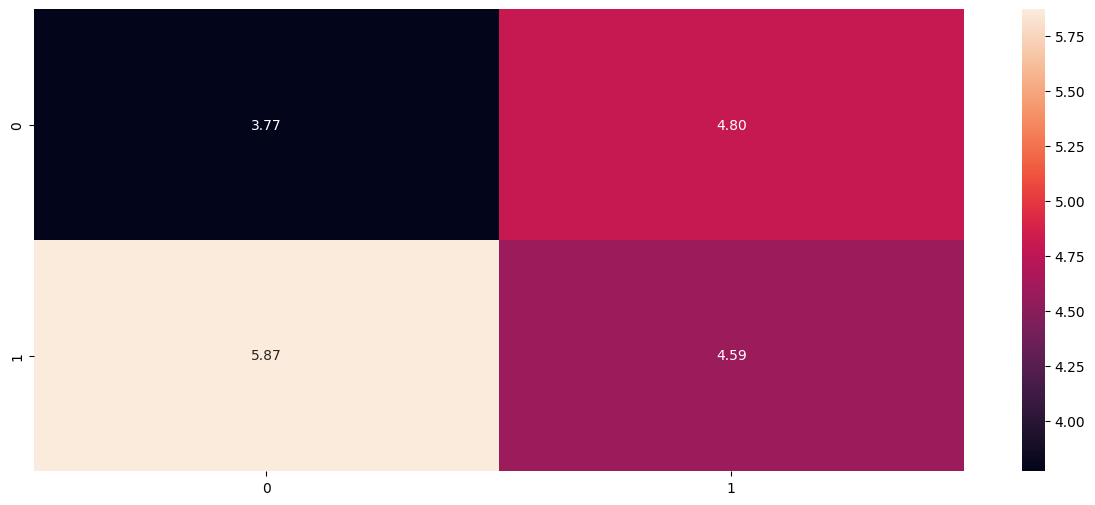

In [23]:
max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
                                           strides=(2, 2), 
                                           padding='valid')

z = max_pool_2d(y)

sns.heatmap(z.numpy()[0,:,:,0], annot=True, fmt=".2f");

## Pooling Layer
>tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
)

Arguments|Description
:--|:--
pool_size|integer or tuple of 2 integers, window size over which to take the maximum. (2, 2) will take the max value over a 2x2 pooling window. If only one integer is specified, the same window length will be used for both dimensions.
strides|Integer, tuple of 2 integers, or None. Strides values. Specifies how far the pooling window moves for each pooling step. If None, it will default to pool_size.
padding|One of "valid" or "same" (case-insensitive). "valid" adds no zero padding. "same" adds padding such that if the stride is 1, the output shape is the same as input shape.
data_format|A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch, height, width, channels) while channels_first corresponds to inputs with shape (batch, channels, height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".

### Create the Convolution base
<img src = '../../images/dnn_nb_cnn_MNIST.png' style = 'width:800px;' alt="Demo Convolution Network MNIST" align="left">

>tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)

>tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
)

In [24]:
# kernel (weight initialization)
krnl_init = tf.keras.initializers.GlorotUniform( seed = RANDOM_STATE)

model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Rescaling(1./255) )

# Convolution 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), # number of filters and filter size
                                 kernel_initializer = krnl_init,
                                 padding='same', 
                                 activation='relu',
                                 input_shape=(28, 28, 1))) # (28 x 28 x 32)
# Pool 1
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # (14 x 14 x 32)

# Convolution 2
model.add(tf.keras.layers.Conv2D(64, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation='relu')) # (12 x 12 x 64)

# Pool 2
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 6 x 6 x 64)

# Convolution 3
model.add(tf.keras.layers.Conv2D(128, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 4 x 4 x 128)

In [25]:
model.add(tf.keras.layers.Flatten())

# Dense 1
model.add(tf.keras.layers.Dense(64,
                                kernel_initializer = krnl_init,
                                activation='relu'))
# Dense 2
model.add(tf.keras.layers.Dense(10))

### Compile and train the model

In [26]:
model.compile(optimizer='adam',
              
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              
              metrics=['accuracy'])

In [27]:
checkpoint_filepath = os.path.join(modelDir, subDir, 'weights_all_in')


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = 'val_loss',
    mode = 'auto',
    save_best_only = True
)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    baseline =None,
    restore_best_weights=True)

In [28]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test_ds)

Epoch 1/10


2024-05-27 20:25:07.534292: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a943c2f6720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-27 20:25:07.534316: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-27 20:25:07.539177: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716821707.613202   31934 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 8s 3ms/step - loss: 0.4445 - accuracy: 0.8388 - val_loss: 0.3240 - val_accuracy: 0.8804
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2832 - accuracy: 0.8967 - val_loss: 0.2946 - val_accuracy: 0.8895
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2356 - accuracy: 0.9136 - val_loss: 0.2857 - val_accuracy: 0.8927
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1997 - accuracy: 0.9269 - val_loss: 0.2585 - val_accuracy: 0.9064
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1696 - accuracy: 0.9378 - val_loss: 0.2513 - val_accuracy: 0.9130
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1448 - accuracy: 0.9462 - val_loss: 0.2508 - val_accuracy: 0.9168
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1259 - accuracy: 0.9533 - val_loss: 0.2708 - val_accuracy: 0.9143
Epo

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         7

In [30]:
res_df = pd.DataFrame(history.history)
res_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.444479,0.838767,0.324014,0.8804
1,0.283172,0.896667,0.294590,0.8895
2,0.235603,0.913650,0.285726,0.8927
3,0.199657,0.926917,0.258487,0.9064
4,0.169642,0.937783,0.251287,0.9130


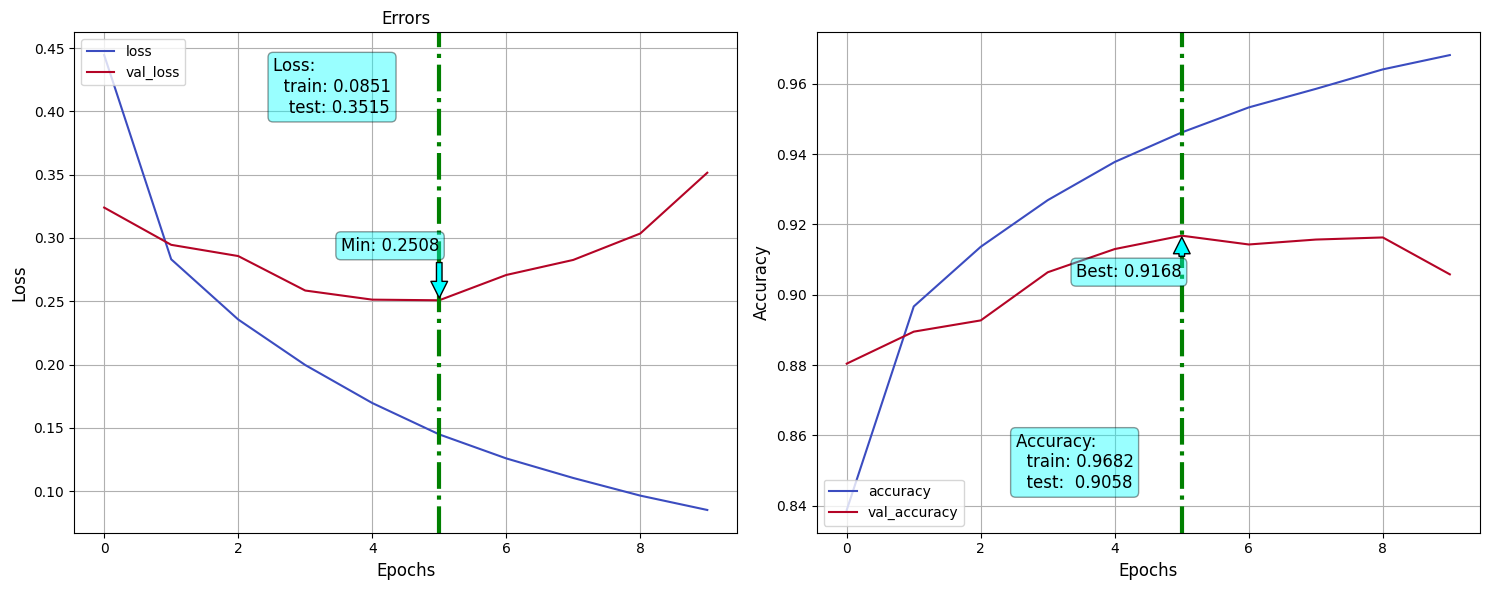

In [31]:
fn_plot_tf_hist(res_df)

### Evaluate the model

In [32]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

313/313 - 0s - loss: 0.3515 - accuracy: 0.9058 - 321ms/epoch - 1ms/step


In [33]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()

In [34]:
yhat = model.predict(test_ds)

y_pred = yhat.argmax(axis = 1)

print(f'Accuracy score on Test Data : {accuracy_score(y_test, y_pred) : .4f}')

313/313 [==============================] - 0s 802us/step
Accuracy score on Test Data :  0.9058



|| |Predicted| class
|:-|:-|:-|:-|
| | |P|N|
Actual|P|TP|FN
class|N|FP|TN

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.82      0.88      0.85      1000
           3       0.88      0.95      0.92      1000
           4       0.83      0.83      0.83      1000
           5       0.99      0.97      0.98      1000
           6       0.83      0.65      0.73      1000
           7       0.97      0.93      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.93      0.98      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.90     10000
weighted avg       0.91      0.91      0.90     10000



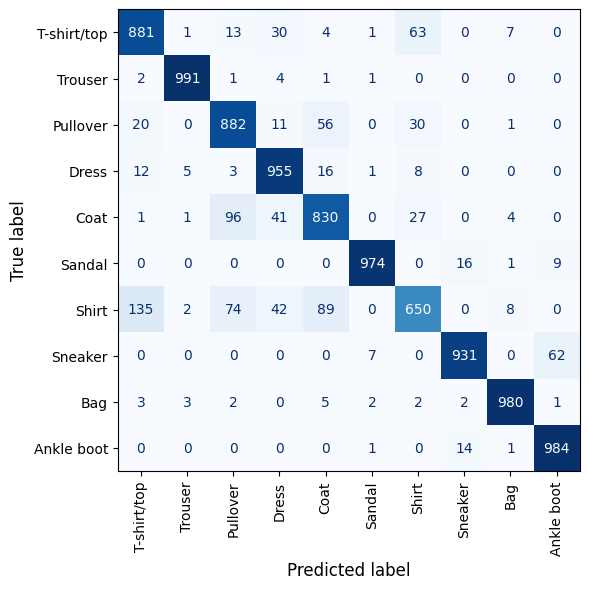

In [36]:
fn_plot_confusion_matrix(y_test, y_pred, class_labels)

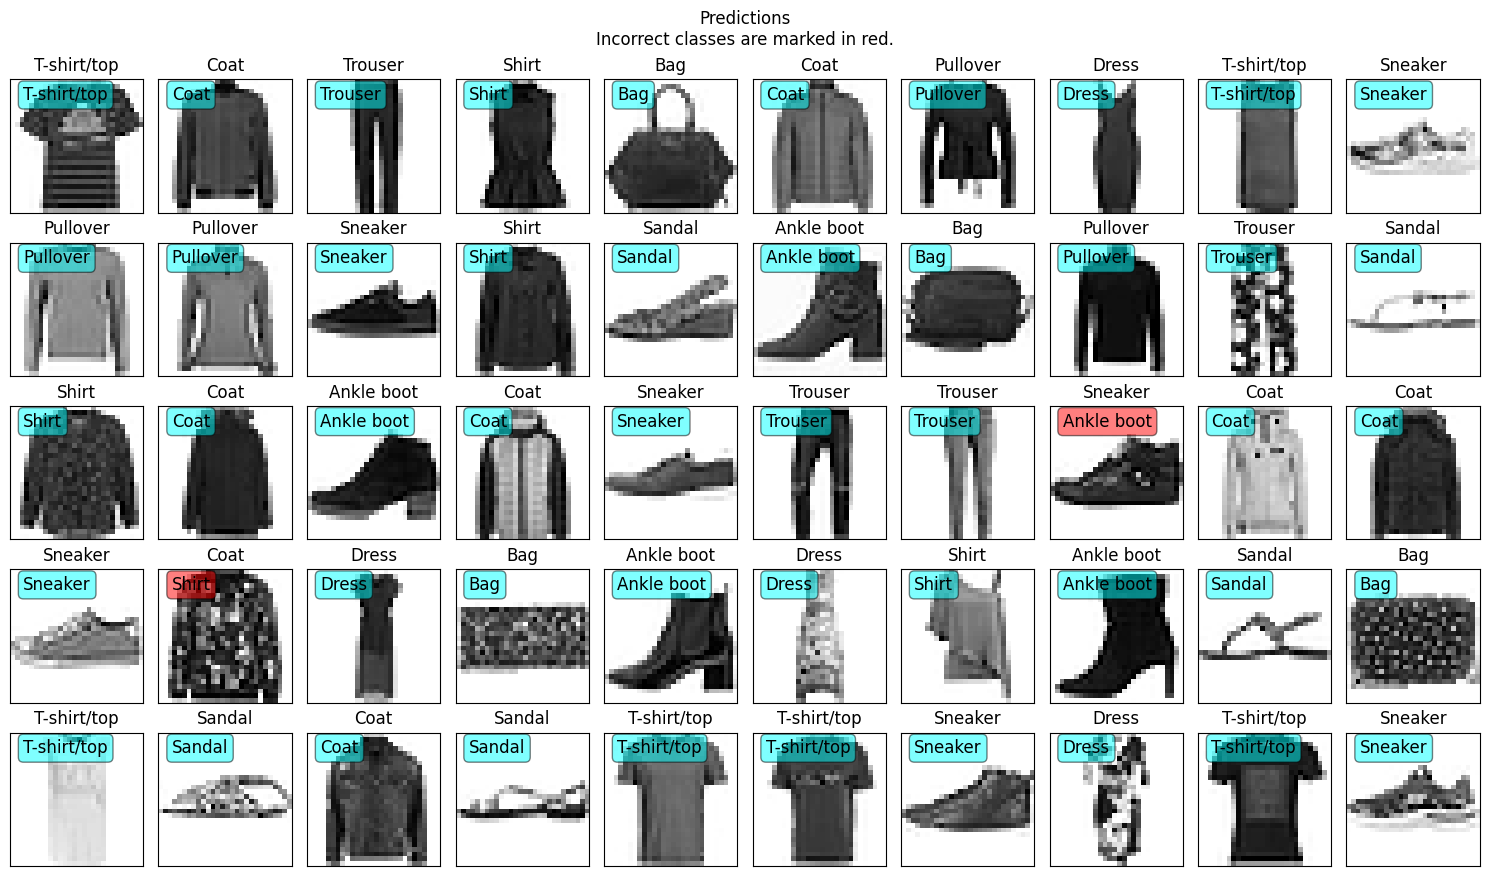

In [37]:
# Results data plot

test_df['y_pred'] = y_pred

plot_df = test_df.sample(n = 50) # Take 50 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

fntsize = 12

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    if row.iloc[0]!= row.iloc[-1]:
        color = 'red'
    else:
        color = 'cyan'
        
    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax = fig.add_subplot(5, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.set_title(class_labels[row.iloc[0]], fontsize=fntsize)   # add number (class) of the image
    
    ax.text(0.1, 0.95, class_labels[row.iloc[-1]], transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)   # add number (class) of the image
    
fig.suptitle('Predictions\nIncorrect classes are marked in red.')
plt.tight_layout()
plt.show()

### Next Steps:
1. Apply L2 regularization
2. Apply Dropout
3. Apply Batch Norm
4. Early stopping